测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


In [2]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

class LSTMclassifier(nn.Module):
    def __init__(self, input_dim,hidden_layer_sizes,output_dim, dropout_rate=0.5):
        """
        LSTM 分类任务  params:
        batch_size       : 批次量大小
        input_dim        : 输入数据的维度
        hidden_layer_size:隐层的数目和维度
        output_dim       : 输出的维度
        dropout_rate     : 随机丢弃神经元的概率
        """
        super().__init__()
        # 批次量大小
        # lstm层数
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()  # 用于保存LSTM层的列表

        # 定义第一层LSTM   
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_layer_sizes[0], batch_first=True))
        
        # 定义后续的LSTM层
        for i in range(1, self.num_layers):
                self.lstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1], hidden_layer_sizes[i], batch_first=True))
                
        # 定义全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )
       
    def forward(self, input_seq):  # torch.Size([16, 512])
        # 前向传播的过程是输入->LSTM层->全连接层->输出
        # 在观察查看LSTM输入的维度，LSTM的第一个输入input_size维度是(batch, seq_length, H_in) batch是batch size , seq_length是序列长度，H_in是输入维度，也就是变量个数
        # LSTM的第二个输入是一个元组，包含了h0,c0两个元素，这两个元素的维度都是（D∗num_layers,N,H_out)，
        # D=1表示单向网络，num_layers表示多少个LSTM层叠加，N是batch size，H_out表示隐层神经元个数

        # 数据预处理
        #改变输入形状，适应网络输入[batch, seq_length, H_in]
        # 注意：这里是 把数据进行了堆叠 把一个1*1024 的序列 进行 划分堆叠成形状为 32 * 32， 就使输入序列的长度降下来了
        # 序列如果 以1024 长度输入进网络，LSTM 容易发生 梯度消失或者爆炸，不容易训练出好结果
        # 当然， 还可以 堆叠 为其他形状的矩阵
        batch_size = input_seq.size(0)
        input_seq = input_seq.view(batch_size, 32, 32) 
        lstm_out = input_seq
        
        for lstm in self.lstm_layers:
            lstm_out, _= lstm(lstm_out)  ## 进行一次LSTM层的前向传播
        # print(lstm_out.size())  # torch.Size([64, 32, 32])
        out = self.classifier(lstm_out[:, -1, :]) # torch.Size([64, 10]  # 仅使用最后一个时间步的输出 
        return out


输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([64, 1, 1024])    torch.Size([64])

In [3]:
# 定义模型参数
input_dim = 32   # 输入维度为一维信号序列堆叠为  32 * 32
hidden_layer_sizes = [256, 128, 64]  # LSTM 层数， 每层 神经元个数
output_dim = 5

model = LSTMclassifier(input_dim, hidden_layer_sizes, output_dim)  
# 定义损失函数和优化函数 

loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.03
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

 32768
262144
  1024
  1024
131072
 65536
   512
   512
 32768
 16384
   256
   256
  4096
    64
   320
     5
______
548741


In [4]:
print(model)

LSTMclassifier(
  (lstm_layers): ModuleList(
    (0): LSTM(32, 256, batch_first=True)
    (1): LSTM(256, 128, batch_first=True)
    (2): LSTM(128, 64, batch_first=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)


注意调整参数，
1. 可以适当增加 LSTM层数 和每层神经元个数，微调学习率；
2. 增加更多的 epochs,  （注意防止过拟合）
3. 但是通过对比实验来看，LSTM对于这种长须列信号的分类能力不如CNN

In [ ]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            # 将模型设置为评估模式
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_lstm.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_lstm.pt')
  
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 5
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

Epoch:  1 train_Loss: 1.61820512 train_Accuracy:0.1955
Epoch:  1 val_Loss:1.61445582,  validate_Acc:0.1935
Epoch:  2 train_Loss: 1.61189871 train_Accuracy:0.1976
Epoch:  2 val_Loss:1.61232740,  validate_Acc:0.1885
Epoch:  3 train_Loss: 1.61138186 train_Accuracy:0.2023
Epoch:  3 val_Loss:1.61123686,  validate_Acc:0.2016
Epoch:  4 train_Loss: 1.61191946 train_Accuracy:0.1954
Epoch:  4 val_Loss:1.60943010,  validate_Acc:0.2077
Epoch:  5 train_Loss: 1.61161351 train_Accuracy:0.1896
Epoch:  5 val_Loss:1.61069525,  validate_Acc:0.1925

Duration: 22 seconds


In [1]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model-lstm.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

NameError: name 'torch' is not defined

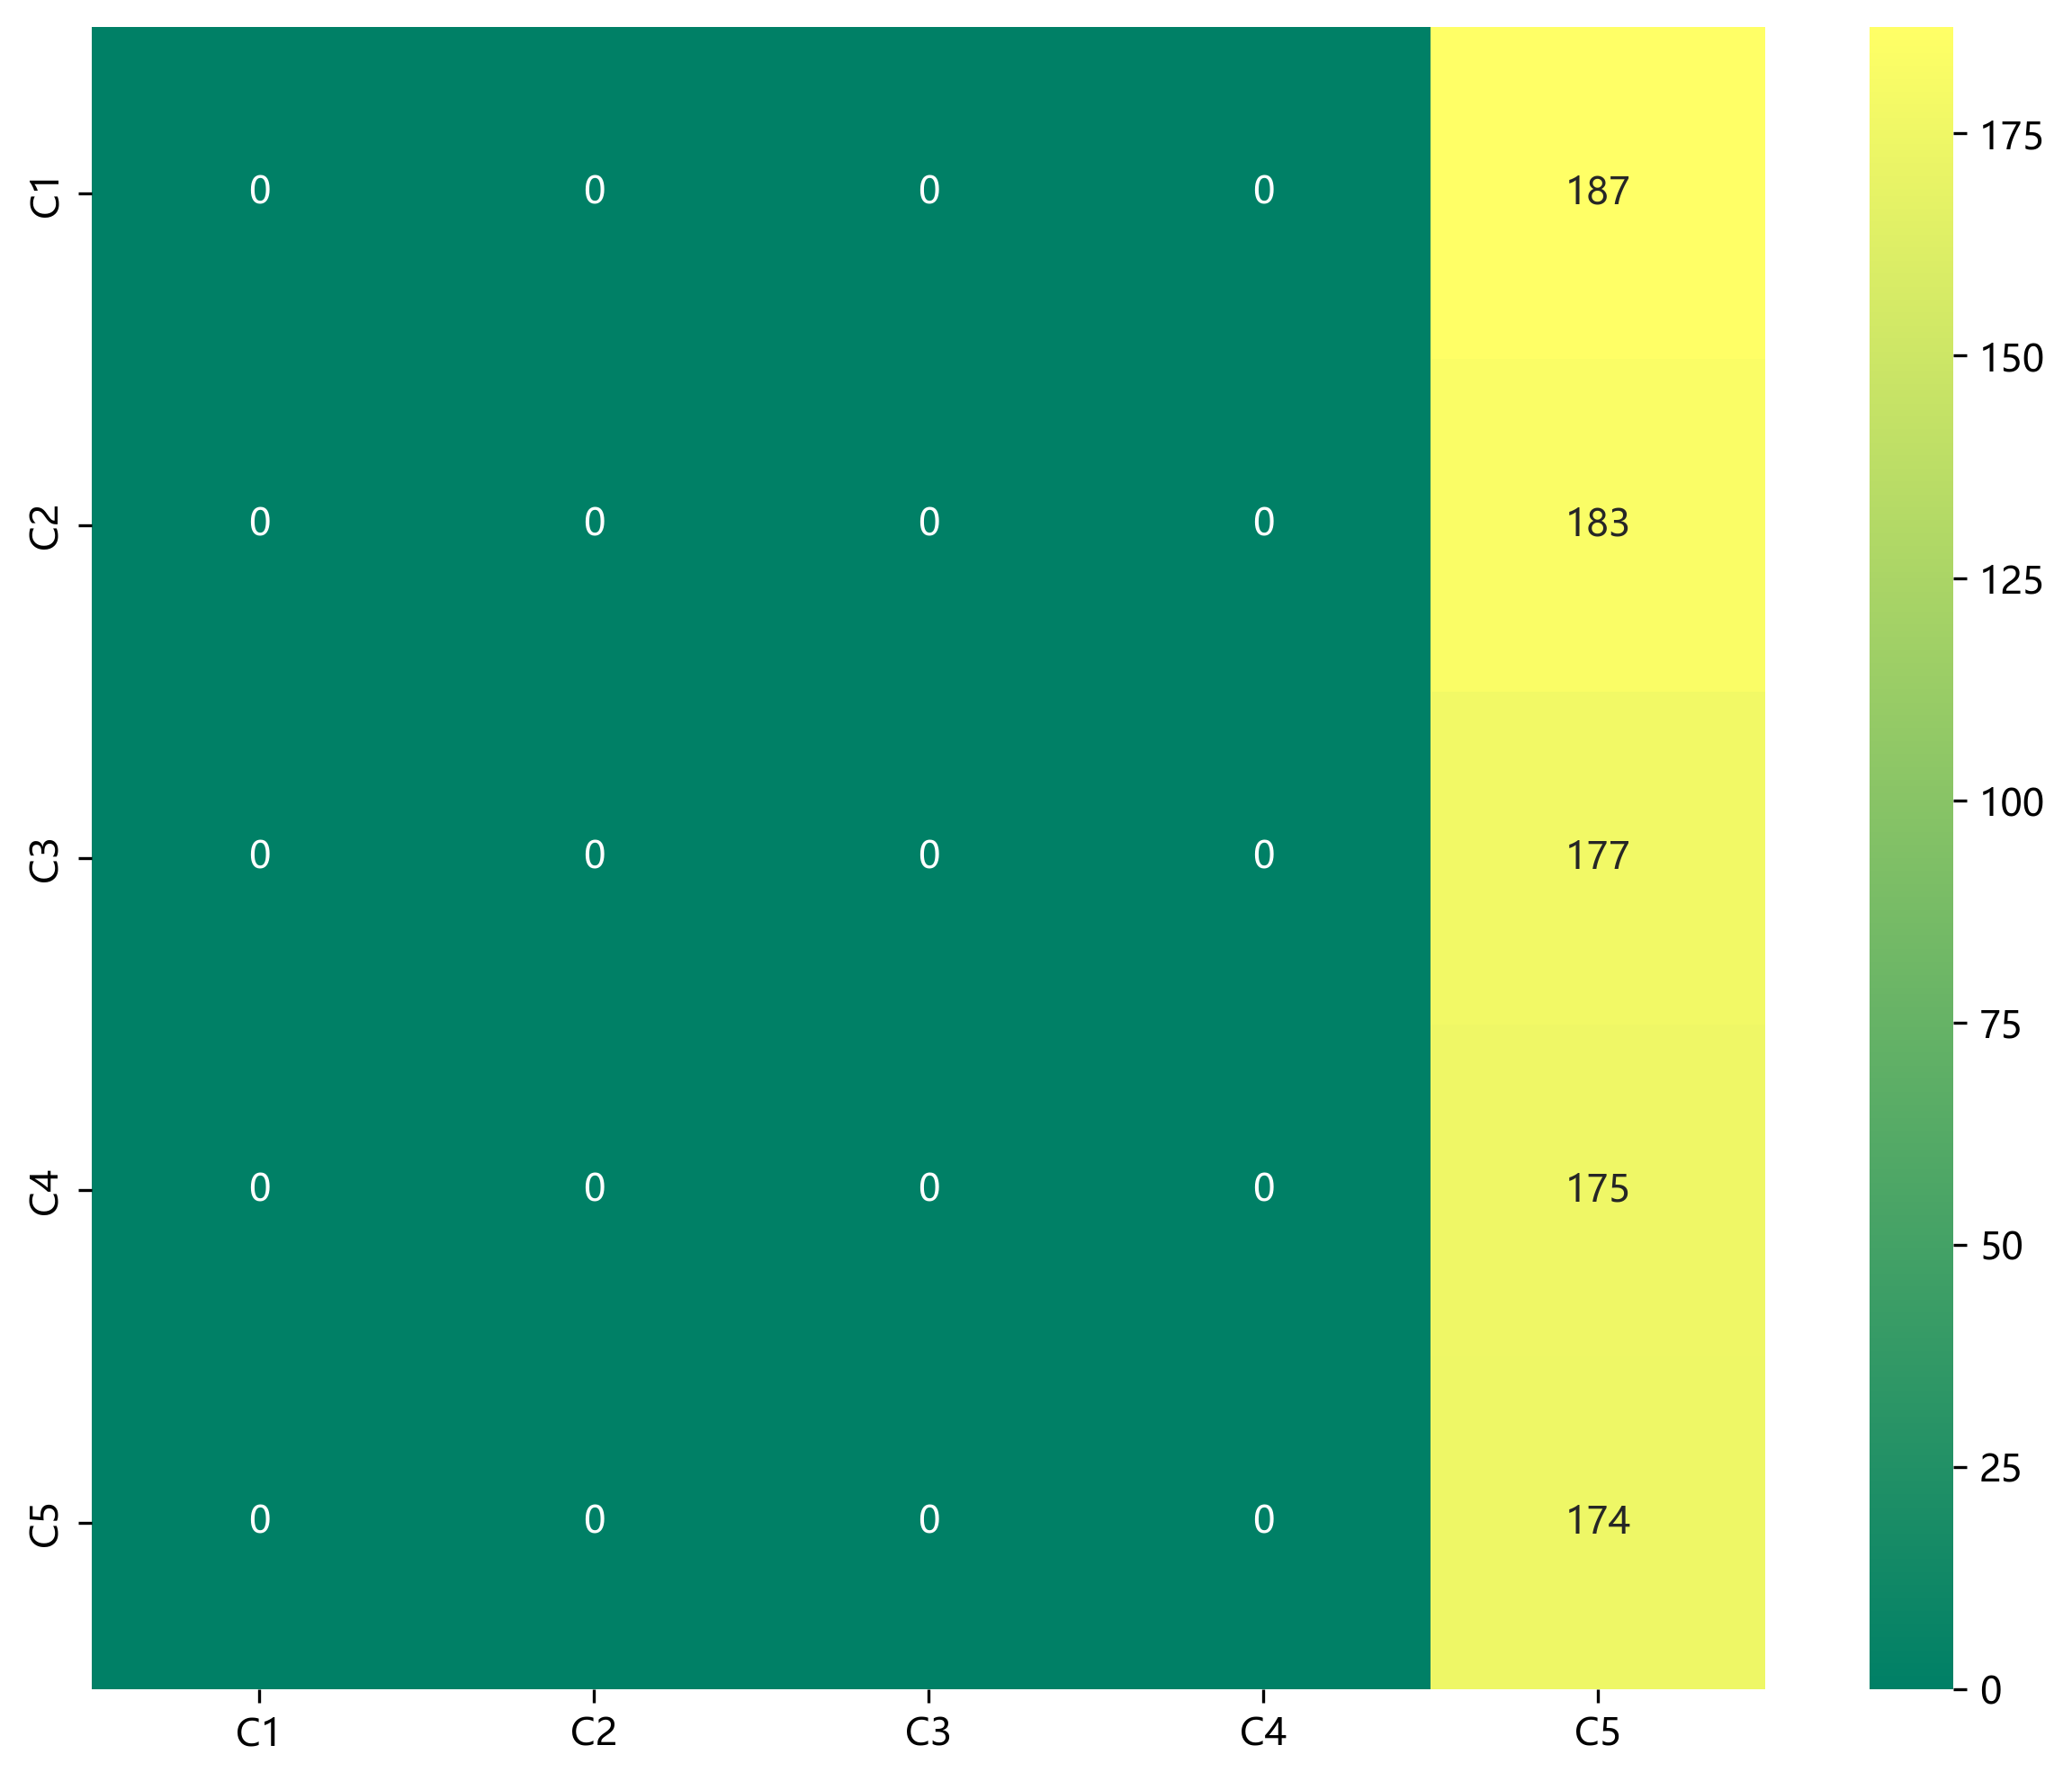

In [28]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()